# Импорт необходимых библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, f1_score, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs


from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_validate
from imblearn.ensemble import BalancedRandomForestClassifier
import xgboost
import lightgbm

from IPython.display import clear_output
from tqdm import tqdm

try:
  import catboost
except ModuleNotFoundError:
  !pip install catboost
  clear_output()
  import catboost

import lightgbm

try:
    import boruta
except ModuleNotFoundError:
    !pip install boruta
    clear_output()
    import boruta

try:
    import optuna
except ModuleNotFoundError:
    !pip install --quiet optuna
    clear_output()
    import optuna


try:
    import shap
except ModuleNotFoundError:
    !pip install shap
    clear_output()
    import shap


from boruta import BorutaPy
import shap


# Загрузка и предобработка данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# data = pd.read_excel("/content/drive/MyDrive/NeuralNetSch/PeakToPeak_P300_all_diff.xlsx")
data = pd.read_excel("Data/PeakToPeak_P300_all_diff.xlsx")

Mounted at /content/drive


## Обзор данных

In [ ]:
data

Name  Diagnosis  P300 O1A50 diff  P300 O2A50 diff  P300 PzA50 diff  \
0   P01          0            1.638            1.505            6.161   
1   P02          0            0.686            0.539            2.745   
2   P03          0           -4.084           -2.899            2.603   
3   P04          0           -0.150           -0.574           -0.983   
4   P05          0            2.900            2.655            4.619   
5   P07          0           -0.790           -1.295            0.427   
6   P08          0            1.128            1.093            3.416   
7   P09          0           -3.202           -4.485           -5.087   
8   P10          0            5.131            3.287            5.382   
9   P11          0            1.217            0.022            1.276   
10  P15          0            4.548            2.697            5.583   
11  P16          0           -2.192           -2.195           -2.344   
12  S01          1            0.623            3.484            4.157   
13  S02          1            2.164            2.557            3.145   
14  S03          1            3.076            2.037            3.886   
15  S04          1            5.142            5.040            8.201   
16  S05          1            1.395            2.941            1.048   
17  S06          1            7.525            9.643            9.189   
18  S07          1            3.961            3.033            3.981   
19  S12          1            0.184           -0.341           -2.467   
20  S13          1           -0.436           -0.239           -0.770   
21  S14          1            2.824           -0.247            0.654   
22  S15          1            1.051            0.505            1.308   
23  S16          1            2.054            0.985            4.409   
24  S17          1            1.056           -0.333            1.446   
25  S19          1           -6.572           -4.164           -5.930   
26  S20          1            2.568            2.591            2.484   
27  S21          1           -0.029           -1.070            0.172   
28  S23          1           -2.246            2.750            1.960   
29  S24          1            1.953            1.429            0.822   
30  S25          1            0.335            0.012            0.116   
31  S26          1           -1.537           -2.272           -3.514   

    P300 FzA50 diff  P300 CzA50 diff  P300 P4A50 diff  P300 P3A50 diff  \
0             4.976            5.736            3.441            5.022   
1             5.049            3.941            3.829            3.711   
2             4.841            7.709            0.720            4.971   
3            -0.566           -0.499           -0.662           -0.797   
4             1.945            6.076            3.211            3.228   
5             0.768            0.994           -1.384            1.325   
6             3.308            3.551            2.175            2.678   
7            -0.145           -2.914           -3.977           -3.423   
8             4.162            5.640            2.086            3.715   
9             2.369            2.268            0.495            3.168   
10            4.760            6.211            3.372            5.448   
11           -1.572           -3.265           -1.277           -0.676   
12            6.145            6.000            4.205            1.693   
13            2.614            0.809            2.187            2.649   
14           -0.548            3.290            2.014            2.772   
15            3.563            9.347            5.187            7.325   
16            1.010            1.761            0.814           -0.760   
17            4.663            7.207            8.489            4.001   
18            1.521            3.528            2.312            2.726   
19           -0.246           -2.617           -2.597           -1.483   
20           -0.724           -0.572   

In [ ]:
data[data['Diagnosis'] == 0].describe()

Diagnosis  P300 O1A50 diff  P300 O2A50 diff  P300 PzA50 diff  \
count       12.0        12.000000        12.000000        12.000000   
mean         0.0         0.569167         0.029167         1.983167   
std          0.0         2.857597         2.416075         3.468847   
min          0.0        -4.084000        -4.485000        -5.087000   
25%          0.0        -1.140500        -1.520000         0.074500   
50%          0.0         0.907000         0.280500         2.674000   
75%          0.0         1.953500         1.792500         4.809750   
max          0.0         5.131000         3.287000         6.161000   

       P300 FzA50 diff  P300 CzA50 diff  P300 P4A50 diff  P300 P3A50 diff  \
count        12.000000        12.000000        12.000000        12.000000   
mean          2.491250         2.954000         1.002417         2.364167   
std           2.391892         3.675403         2.445236         2.735391   
min          -1.572000        -3.265000        -3.977000        -3.423000   
25%           0.539750         0.620750        -0.815750         0.824750   
50%           2.838500         3.746000         1.403000         3.198000   
75%           4.780250         5.821000         3.251250         4.029000   
max           5.049000         7.709000         3.829000         5.448000   

       P300 C4A50 diff  P300 C3A50 diff  ...  P300 FzA80 diff  \
count        12.000000        12.000000  ...        12.000000   
mean          1.500750         2.948583  ...         5.597167   
std           2.614979         3.088127  ...         2.109269   
min          -4.249000        -1.819000  ...         1.782000   
25%           0.112250         1.269250  ...         4.769500   
50%           2.060500         3.262000  ...         5.752500   
75%           3.418000         4.663500  ...         7.458000   
max           4.424000         7.602000  ...         8.427000   

       P300 CzA80 diff  P300 P4A80 diff  P300 P3A80 diff  P300 C4A80 diff  \
count        12.000000        12.000000        12.000000        12.000000   
mean          5.705500         3.426333         3.987917         4.388250   
std           1.796849         2.791434         2.753893         2.648387   
min           2.899000        -0.792000         0.137000         0.458000   
25%           4.730000         1.533750         1.515500         2.798250   
50%           5.129000         3.969000         4.954000         4.232500   
75%           7.271500         5.380000         6.356500         5.423500   
max           8.996000         7.027000         7.243000        10.777000   

       P300 C3A80 diff  P300 F3A80 diff  P300 F4A80 diff  P300 T5A80 diff  \
count        12.000000         12.00000        12.000000        12.000000   
mean          4.516583          3.65400         4.322167         3.003333   
std           2.415612          2.13840         1.892876         2.057460   
min           1.596000         -0.04600         2.252000        -0.159000   
25%           2.560750          2.26850         3.207000         1.210500   
50%           3.943500          3.37900         3.891500         3.419500   
75%           6.084000          4.58975         4.750750         4.674250   
max           8.743000          7.60700         8.313000         5.534000   

       P300 T6A80 diff  
count        12.000000  
mean          2.826250  
std           2.282374  
min          -0.670000  
25%           1.319250  
50%           2.820500  
75%           4.343000  
max           7.308000  

[8 rows x 27 columns]

In [ ]:
data[data['Diagnosis'] == 1].describe()

Diagnosis  P300 O1A50 diff  P300 O2A50 diff  P300 PzA50 diff  \
count       20.0        20.000000        20.000000        20.000000   
mean         1.0         1.254550         1.417050         1.714850   
std          0.0         2.897492         2.905867         3.559204   
min          1.0        -6.572000        -4.164000        -5.930000   
25%          1.0         0.130750        -0.268500         0.158000   
50%          1.0         1.225500         1.207000         1.377000   
75%          1.0         2.632000         2.797750         3.909750   
max          1.0         7.525000         9.643000         9.189000   

       P300 FzA50 diff  P300 CzA50 diff  P300 P4A50 diff  P300 P3A50 diff  \
count         20.00000        20.000000        20.000000        20.000000   
mean           0.82805         1.708300         0.992150         0.979200   
std            2.17644         3.309158         2.894614         2.736304   
min           -2.54900        -3.970000        -3.088000        -4.880000   
25%           -0.59200        -0.606500        -1.218250        -0.905500   
50%            0.55550         1.484000         1.000500         0.571500   
75%            1.63350         3.307500         2.209250         2.727500   
max            6.14500         9.347000         8.489000         7.325000   

       P300 C4A50 diff  P300 C3A50 diff  ...  P300 FzA80 diff  \
count        20.000000        20.000000  ...        20.000000   
mean          0.721500         1.219000  ...         0.602350   
std           2.781357         2.585347  ...         2.442135   
min          -5.571000        -2.326000  ...        -2.799000   
25%          -1.657250        -0.819750  ...        -1.449250   
50%           1.520500         0.986000  ...         0.362000   
75%           2.282250         2.597250  ...         2.881750   
max           4.696000         7.642000  ...         4.790000   

       P300 CzA80 diff  P300 P4A80 diff  P300 P3A80 diff  P300 C4A80 diff  \
count        20.000000        20.000000        20.000000        20.000000   
mean          0.626150        -0.141450        -0.157050         0.094750   
std           2.490943         1.834131         2.009008         1.737428   
min          -4.237000        -4.186000        -5.846000        -3.018000   
25%          -0.892750        -0.231750        -1.274000        -0.960750   
50%           0.532000         0.065000         0.162000         0.055500   
75%           2.927750         0.629000         0.827750         1.349250   
max           4.724000         2.796000         3.248000         3.367000   

       P300 C3A80 diff  P300 F3A80 diff  P300 F4A80 diff  P300 T5A80 diff  \
count        20.000000        20.000000        20.000000        20.000000   
mean          0.431450         0.770800         0.133950        -0.875400   
std           1.778252         2.252007         1.977718         1.839524   
min          -2.856000        -3.661000        -3.127000        -5.089000   
25%          -0.769500        -1.224250        -1.124250        -1.760500   
50%           0.674500         0.524500        -0.071500        -0.507000   
75%           1.152750         3.115250         1.272000         0.280500   
max           4.041000         4.205000         3.797000         1.880000   

       P300 T6A80 diff  
count        20.000000  
mean         -0.361700  
std           1.672899  
min          -2.794000  
25%          -1.648500  
50%          -0.436500  
75%           0.680000  
max           3.371000  

[8 rows x 27 columns]

In [ ]:
x = data.drop(['Name', "Diagnosis"], axis=1)
y = data["Diagnosis"]

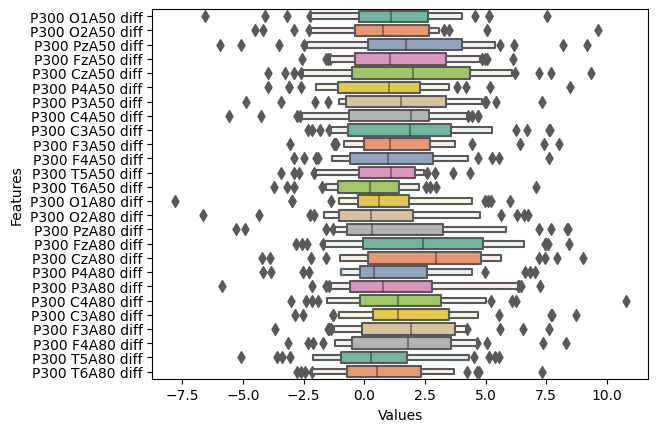

In [ ]:
ax = sns.boxenplot(data=x, orient="h", palette="Set2")
ax.set(xlabel="Values", ylabel="Features")
plt.show()

## Разбиение на части и стандартизация

In [ ]:
def split_and_norm_data(x, y, random_state):
  stScaler = StandardScaler()
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=random_state, stratify = y)
  stScaler.fit(x_train)
  x_train = stScaler.transform(x_train)
  x_test = stScaler.transform(x_test)
  return x_train, x_test, y_train, y_test

In [ ]:
x_np = np.array(x)
y_np = np.array(y)
x_train, x_test, y_train, y_test = split_and_norm_data(x_np, y_np, random_state = 5)
print(f'Размер x_train = {x_train.shape}, размер x_test = {x_test.shape}')

Размер x_train = (22, 26), размер x_test = (10, 26)


# Функции для оценки качества и визуализации

In [ ]:
def cv_on_diff_seeds (clf, x, y, n_folds = 4, n_states = 100):
    fold_scores = []
    test_scores = []
    for i in tqdm(range(n_states)):
        x_train, x_test, y_train, y_test = split_and_norm_data(x, y, random_state = i)
        fold_values = cross_validate(clf, x_train, y_train, n_jobs=-1, cv=n_folds, scoring='f1', return_estimator = True)
        fold_scores.append(list(fold_values['test_score']))
        test_values = []
        for estimator in fold_values['estimator']:
            test_values.append(f1_score(estimator.predict(x_test), y_test))
        test_scores.append(test_values)

    folds_mean = np.mean(np.array(fold_scores), axis = 0)
    tests_mean = np.mean(np.array(test_scores), axis = 0)

    folds_std = np.std(np.array(fold_scores), axis = 0)
    tests_std = np.std(np.array(test_scores), axis = 0)

    df_for_viz = pd.concat(axis=1, ignore_index=False, objs=[
      pd.DataFrame.from_dict({'estimator': 2*[f'estimator{i}' for i in range(1, n_folds+1)]}),
      pd.DataFrame.from_dict({'condition': n_folds*['fold'] + n_folds*['test']}),
      pd.DataFrame.from_dict({'f1_score': list(folds_mean) + list(tests_mean)}),
      pd.DataFrame.from_dict({'std': list(folds_std) + list(tests_std)})])
    return folds_mean, tests_mean, folds_std, tests_std, df_for_viz,

def viz_cv (df, title = None):
  plt.figure(figsize=(16, 6))
  sns.barplot(x ='estimator', y = 'f1_score', data = df, hue='condition', palette = "pastel")
  plt.errorbar(x=[-0.2, 0.8, 1.8, 2.8],y=df[df['condition'] == 'fold']['f1_score'],
              yerr=df[df['condition'] == 'fold']['std'], fmt='none', c= 'b')
  plt.errorbar(x=[0.2, 1.2, 2.2, 3.2],y=df[df['condition'] == 'test']['f1_score'],
              yerr=df[df['condition'] == 'test']['std'], fmt='none', c= 'r')
  if title != None:
    plt.title(f'{title} f1_score')


In [ ]:
def test_on_diff_seeds (clf, x, y, n_states = 100):
    f1_scores = []
    recall_scores = []
    precision_scores = []
    support_scores = []
    for i in range(n_states):
        x_train, x_test, y_train, y_test = split_and_norm_data(x, y, random_state = i)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        prec, rec, f, sup = precision_recall_fscore_support (y_pred, y_test)
        f1_scores.append(f)
        recall_scores.append(rec)
        precision_scores.append(prec)
        support_scores.append(sup)
    return classification_report_on_diff_seeds(f1_scores, recall_scores, precision_scores, support_scores)

def classification_report_on_diff_seeds (f1_scores, recall_scores, precision_scores, support_scores):
      df = pd.concat(axis=1, ignore_index=False, objs=[
          pd.DataFrame.from_dict({'classes': [0, 1, 'average']}),
          pd.DataFrame.from_dict({'precision_mean': np.append(np.mean(precision_scores, axis = 0), np.mean(precision_scores))}),
          # pd.DataFrame.from_dict({'precision_std': np.std(precision_scores, axis = 0)}),
          pd.DataFrame.from_dict({'recall_mean': np.append(np.mean(recall_scores, axis = 0), np.mean(recall_scores))}),
          # pd.DataFrame.from_dict({'recall_std': np.std(recall_scores, axis = 0)}),
          pd.DataFrame.from_dict({'f1_mean': np.append(np.mean(f1_scores, axis = 0), np.mean(f1_scores))}),
          # pd.DataFrame.from_dict({'f1_std': np.std(f1_scores, axis = 0)})
          ])


      return df

In [ ]:
def feature_selection (clf, x_train, y_train, k_features = 20, scoring = 'f1', n_splits = 4, random_state = 1):
    sffs = SequentialFeatureSelector(
           clf, # represents the classifier
           k_features=k_features, # the number of features you want to select
           forward=True, # add features
           floating=True, # remove features
           scoring=scoring, # means that the selection will be decided by the f1 of the classifier.
           cv=KFold(n_splits=n_splits, shuffle=True, random_state=random_state))

    sffs.fit(x_train, y_train) #performs the actual SFFS algorithm
    df_sffs = pd.DataFrame.from_dict(sffs.get_metric_dict()).T
    df_sffs.head(df_sffs.shape[0])
    max_idx = len(np.array(df_sffs['avg_score'])) - np.argmax(np.array(df_sffs['avg_score'])[::-1]) - 1
    feature_idxs = list(map(int, df_sffs['feature_names'].iloc[max_idx]))
    return feature_idxs


# Baseline

## Random Forest

### Подбор гиперпараметров

In [ ]:
def objective_RF(trial):

    n_estimators = trial.suggest_int('n_estimators', 2, 20)
    max_depth = int(trial.suggest_int('max_depth', 1, 32, log=True))

    clf = RandomForestClassifier(
        n_estimators=n_estimators, max_depth=max_depth, random_state = 83)

    values = cross_val_score(
        clf, x_train, y_train, n_jobs=-1, cv=4, scoring='f1')

    return values.mean()


study_RF = optuna.create_study(direction='maximize')
study_RF.optimize(objective_RF, n_trials=100)

trial_RF = study_RF.best_trial

print('RANDOM FOREST BEST F1: {}'.format(trial_RF.value))
print("Best hyperparameters: {}".format(trial_RF.params))

[I 2023-11-22 17:32:34,171] A new study created in memory with name: no-name-d5638870-af19-40e4-8509-0cba55bff771
[I 2023-11-22 17:32:34,224] Trial 0 finished with value: 0.8517857142857144 and parameters: {'n_estimators': 4, 'max_depth': 1}. Best is trial 0 with value: 0.8517857142857144.
[I 2023-11-22 17:32:34,294] Trial 1 finished with value: 0.8865079365079366 and parameters: {'n_estimators': 8, 'max_depth': 22}. Best is trial 1 with value: 0.8865079365079366.
[I 2023-11-22 17:32:34,405] Trial 2 finished with value: 0.8865079365079366 and parameters: {'n_estimators': 19, 'max_depth': 23}. Best is trial 1 with value: 0.8865079365079366.
[I 2023-11-22 17:32:34,469] Trial 3 finished with value: 0.8865079365079366 and parameters: {'n_estimators': 8, 'max_depth': 32}. Best is trial 1 with value: 0.8865079365079366.
[I 2023-11-22 17:32:34,515] Trial 4 finished with value: 0.8517857142857144 and parameters: {'n_estimators': 4, 'max_depth': 30}. Best is trial 1 with value: 0.88650793650793

RANDOM FOREST BEST F1: 0.9365079365079365
Best hyperparameters: {'n_estimators': 17, 'max_depth': 13}


### Оценка

In [ ]:
RF = RandomForestClassifier(n_estimators=trial_RF.params['n_estimators'], max_depth=trial_RF.params['max_depth'], random_state = 40)
folds_mean_rf, tests_mean_rf, folds_std_rf, tests_std_rf, df_rf = cv_on_diff_seeds(RF, x, y, 4, 100)

100%|██████████| 100/100 [00:17<00:00,  5.74it/s]


In [ ]:
feature_idxs_rf = feature_selection(RF, x_train, y_train)
folds_mean_rf_red, tests_mean_rf_red, folds_std_rf_red, tests_std_rf_red, df_rf_red = cv_on_diff_seeds(RF, x_np[:,feature_idxs_rf], y_np)
print(f'Most importante features: {x.columns[feature_idxs_rf]}')

100%|██████████| 100/100 [00:16<00:00,  6.15it/s]

Most importante features: Index(['P300 O2A50 diff', 'P300 FzA50 diff', 'P300 C3A50 diff',
       'P300 T6A50 diff', 'P300 FzA80 diff', 'P300 CzA80 diff',
       'P300 P4A80 diff', 'P300 C3A80 diff'],
      dtype='object')


Folds mean = 0.8782242063492061, Folds std = 0.11391876080990818
Tests mean = 0.8713015318015311, Tests std = 0.0880279658109383


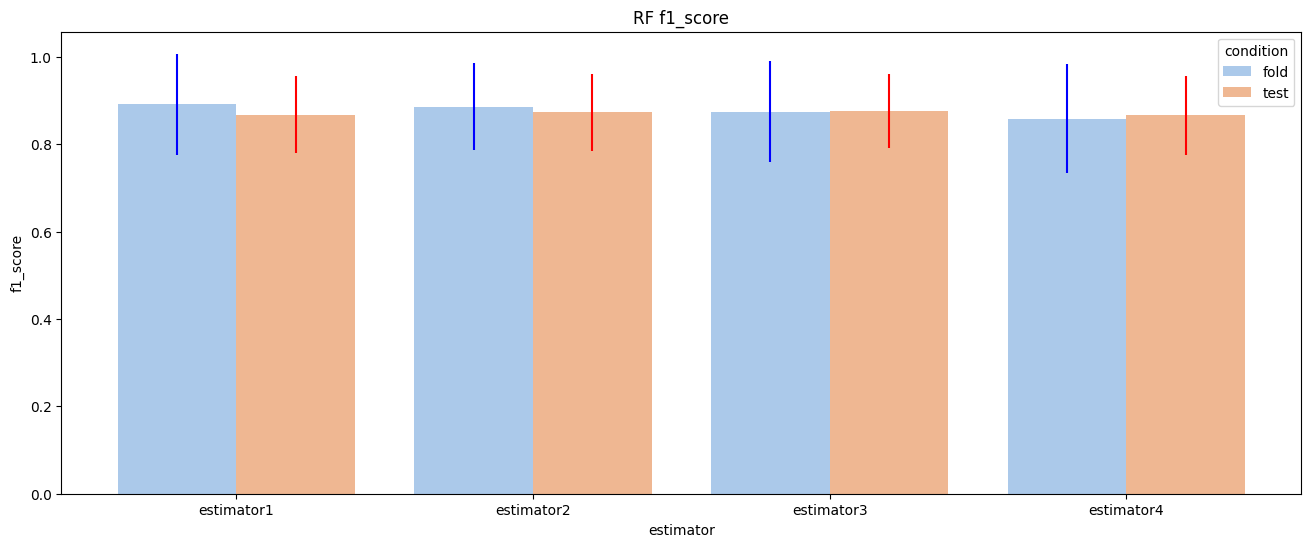

In [ ]:
print(f'Folds mean = {np.mean(folds_mean_rf)}, Folds std = {np.mean(folds_std_rf)}')
print(f'Tests mean = {np.mean(tests_mean_rf)}, Tests std = {np.mean(tests_std_rf)}')

viz_cv(df_rf, title = 'RF')

Folds mean = 0.9173730158730156, Folds std = 0.10168583333935499
Tests mean = 0.9172013819513809, Tests std = 0.07619236651018349


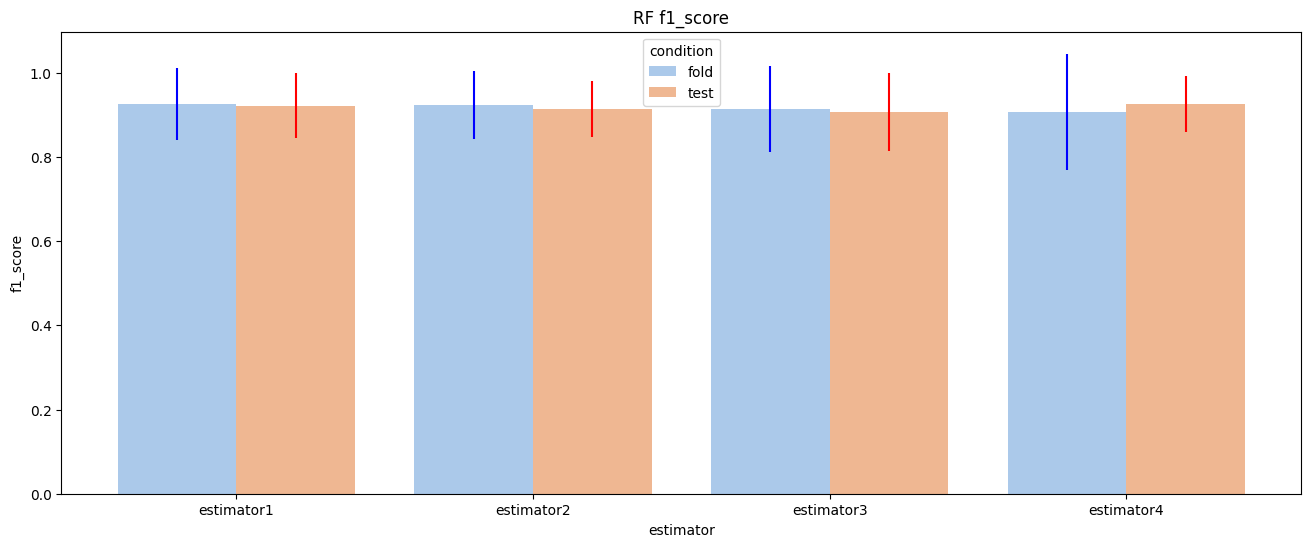

In [ ]:
print(f'Folds mean = {np.mean(folds_mean_rf_red)}, Folds std = {np.mean(folds_std_rf_red)}')
print(f'Tests mean = {np.mean(tests_mean_rf_red)}, Tests std = {np.mean(tests_std_rf_red)}')
viz_cv(df_rf_red, title = 'RF')

In [ ]:
test_on_diff_seeds(RF, x, y)

classes  precision_mean  recall_mean   f1_mean
0        0          0.7700     0.872500  0.794802
1        1          0.9050     0.868643  0.878758
2  average          0.8375     0.870571  0.836780

In [ ]:
test_on_diff_seeds(RF, x_np[:,feature_idxs_rf], y_np)

classes  precision_mean  recall_mean   f1_mean
0        0        0.870000     0.933000  0.884508
1        1        0.943333     0.927619  0.928462
2  average        0.906667     0.930310  0.906485

## Balanced Random Forest

### Подбор гиперпараметров

In [ ]:
def objective_BRF(trial):

    n_estimators = trial.suggest_int('n_estimators', 2, 20)
    max_depth = int(trial.suggest_float('max_depth', 1, 32, log=True))

    clf = BalancedRandomForestClassifier(
        n_estimators=n_estimators, max_depth=max_depth, random_state = 83)

    values = cross_val_score(
        clf, x_train, y_train, n_jobs=-1, cv=4, scoring='f1')

    return values.mean()

study_BRF = optuna.create_study(direction='maximize')
study_BRF.optimize(objective_BRF, n_trials=100)

trial_BRF = study_BRF.best_trial

print('Balanced RANDOM FOREST BEST F1: {}'.format(trial_BRF.value))
print("Best hyperparameters: {}".format(trial_BRF.params))

[I 2023-11-22 17:34:07,997] A new study created in memory with name: no-name-357c4049-5cac-4600-9d70-54393ac41fa0
[I 2023-11-22 17:34:08,244] Trial 0 finished with value: 0.8472222222222222 and parameters: {'n_estimators': 15, 'max_depth': 30.258548193337607}. Best is trial 0 with value: 0.8472222222222222.
[I 2023-11-22 17:34:08,448] Trial 1 finished with value: 0.7625 and parameters: {'n_estimators': 12, 'max_depth': 10.07916039354316}. Best is trial 0 with value: 0.8472222222222222.
[I 2023-11-22 17:34:08,732] Trial 2 finished with value: 0.8875 and parameters: {'n_estimators': 19, 'max_depth': 1.406594080845502}. Best is trial 2 with value: 0.8875.
[I 2023-11-22 17:34:08,853] Trial 3 finished with value: 0.7972222222222223 and parameters: {'n_estimators': 7, 'max_depth': 3.8479112179099175}. Best is trial 2 with value: 0.8875.
[I 2023-11-22 17:34:08,998] Trial 4 finished with value: 0.8722222222222222 and parameters: {'n_estimators': 9, 'max_depth': 1.3293904421166776}. Best is tri

Balanced RANDOM FOREST BEST F1: 0.9222222222222223
Best hyperparameters: {'n_estimators': 20, 'max_depth': 1.310905811062611}


### Оценка

In [ ]:
BRF = BalancedRandomForestClassifier(n_estimators=trial_BRF.params['n_estimators'], max_depth=int(trial_BRF.params['max_depth']), random_state = 40)
folds_mean_brf, tests_mean_brf, folds_std_brf, tests_std_brf, df_brf = cv_on_diff_seeds(BRF, x, y)

100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


In [ ]:
feature_idxs_brf = feature_selection(BRF, x_train, y_train)
clear_output()
folds_mean_brf_red, tests_mean_brf_red, folds_std_brf_red, tests_std_brf_red, df_brf_red = cv_on_diff_seeds(BRF, x_np[:,feature_idxs_brf], y_np)
print(f'Most importante features: {x.columns[feature_idxs_brf]}')

100%|██████████| 100/100 [00:40<00:00,  2.47it/s]

Most importante features: Index(['P300 O1A50 diff', 'P300 O2A50 diff', 'P300 PzA50 diff',
       'P300 FzA50 diff', 'P300 CzA50 diff', 'P300 P4A50 diff',
       'P300 P3A50 diff', 'P300 F3A50 diff', 'P300 PzA80 diff',
       'P300 FzA80 diff', 'P300 CzA80 diff', 'P300 P3A80 diff',
       'P300 C4A80 diff', 'P300 C3A80 diff', 'P300 F3A80 diff',
       'P300 T5A80 diff', 'P300 T6A80 diff'],
      dtype='object')


Folds mean = 0.8494781746031743, Folds std = 0.14122374138304047
Tests mean = 0.8489338439338433, Tests std = 0.11120675132701309


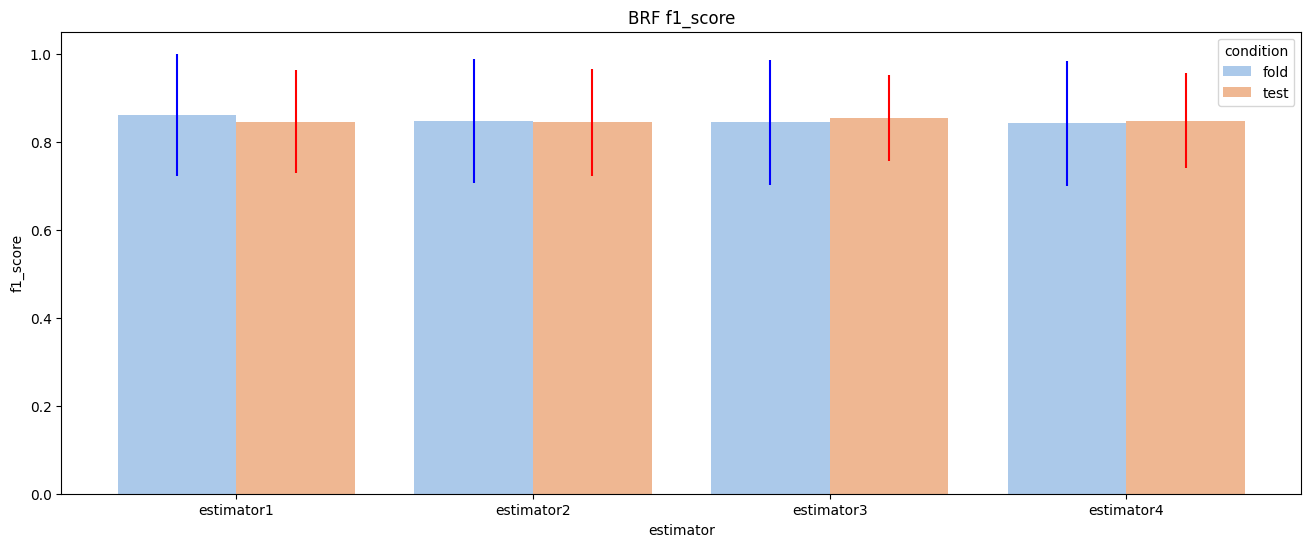

In [ ]:
print(f'Folds mean = {np.mean(folds_mean_brf)}, Folds std = {np.mean(folds_std_brf)}')
print(f'Tests mean = {np.mean(tests_mean_brf)}, Tests std = {np.mean(tests_std_brf)}')

viz_cv(df_brf, title = 'BRF')

Folds mean = 0.865849206349206, Folds std = 0.14151447064159026
Tests mean = 0.8633017815517806, Tests std = 0.11323277926230504


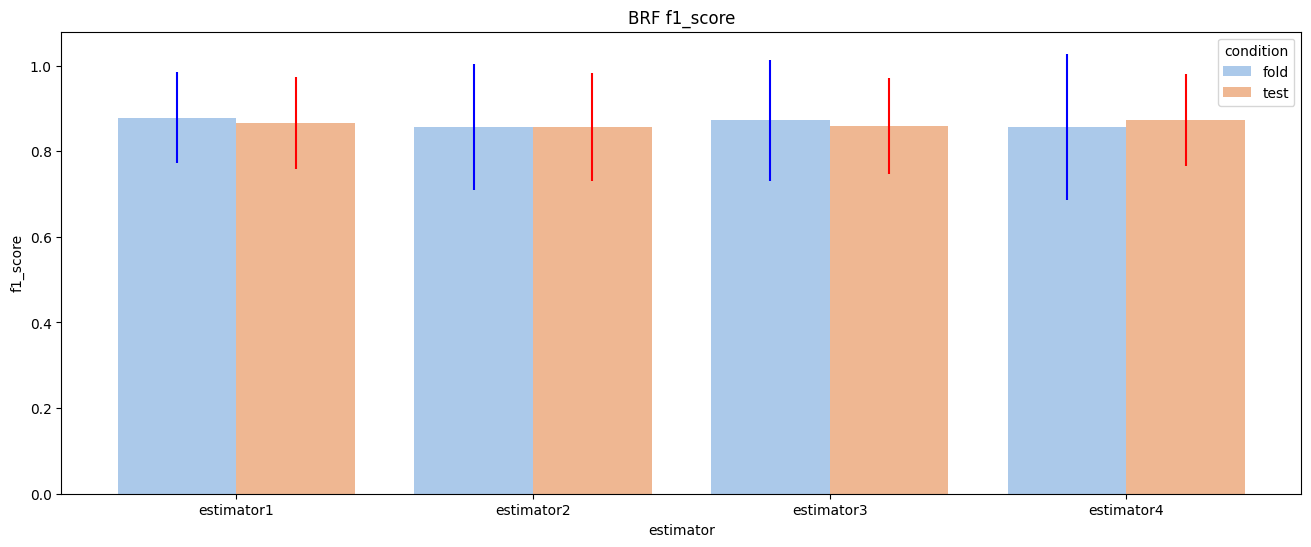

In [ ]:
print(f'Folds mean = {np.mean(folds_mean_brf_red)}, Folds std = {np.mean(folds_std_brf_red)}')
print(f'Tests mean = {np.mean(tests_mean_brf_red)}, Tests std = {np.mean(tests_std_brf_red)}')
viz_cv(df_brf_red, title = 'BRF')

In [ ]:
test_on_diff_seeds(BRF, x, y)

Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible 

classes  precision_mean  recall_mean   f1_mean
0        0         0.88250     0.807738  0.824054
1        1         0.82500     0.927786  0.860965
2  average         0.85375     0.867762  0.842509

In [ ]:
test_on_diff_seeds(BRF, x_np[:,feature_idxs_brf], y_np)

Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible 

classes  precision_mean  recall_mean   f1_mean
0        0        0.922500     0.813206  0.850382
1        1        0.833333     0.952238  0.878452
2  average        0.877917     0.882722  0.864417

## Decision Tree

### Подбор гиперпараметров

In [ ]:
def objective_DT(trial):

    max_depth = trial.suggest_int('max_depth', 2, 64)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 32)

    clf = DecisionTreeClassifier(
        max_depth=max_depth, min_samples_leaf=min_samples_leaf)

    values = cross_val_score(
        clf, x_train, y_train, n_jobs=-1, cv=4, scoring='f1')

    return values.mean()

study_DT = optuna.create_study(direction='maximize')
study_DT.optimize(objective_DT, n_trials=100)

trial_DT = study_DT.best_trial

print('Decision TREE BEST F1: {}'.format(trial_DT.value))
print("Best hyperparameters: {}".format(trial_DT.params))



[I 2023-11-22 17:36:01,821] A new study created in memory with name: no-name-ac669163-ef67-4134-b72c-173645557c66
[I 2023-11-22 17:36:01,849] Trial 0 finished with value: 0.775 and parameters: {'max_depth': 46, 'min_samples_leaf': 15}. Best is trial 0 with value: 0.775.
[I 2023-11-22 17:36:01,877] Trial 1 finished with value: 0.8031746031746032 and parameters: {'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8031746031746032.
[I 2023-11-22 17:36:01,900] Trial 2 finished with value: 0.775 and parameters: {'max_depth': 25, 'min_samples_leaf': 18}. Best is trial 1 with value: 0.8031746031746032.
[I 2023-11-22 17:36:01,927] Trial 3 finished with value: 0.775 and parameters: {'max_depth': 12, 'min_samples_leaf': 17}. Best is trial 1 with value: 0.8031746031746032.
[I 2023-11-22 17:36:01,955] Trial 4 finished with value: 0.775 and parameters: {'max_depth': 20, 'min_samples_leaf': 31}. Best is trial 1 with value: 0.8031746031746032.
[I 2023-11-22 17:36:01,982] Trial 5 f

Decision TREE BEST F1: 0.8865079365079365
Best hyperparameters: {'max_depth': 38, 'min_samples_leaf': 1}


### Оценка

In [ ]:
DT = DecisionTreeClassifier(
        max_depth=trial_DT.params['max_depth'], min_samples_leaf=trial_DT.params['min_samples_leaf'], random_state = 40)

folds_mean_dt, tests_mean_dt, folds_std_dt, tests_std_dt, df_dt = cv_on_diff_seeds(DT, x, y)

100%|██████████| 100/100 [00:04<00:00, 24.65it/s]


In [ ]:
feature_idxs_dt = feature_selection(DT, x_train, y_train)
folds_mean_dt_red, tests_mean_dt_red, folds_std_dt_red, tests_std_dt_red, df_dt_red = cv_on_diff_seeds(DT, x_np[:,feature_idxs_dt], y_np)
print(f'Most importante features: {x.columns[feature_idxs_dt]}')

100%|██████████| 100/100 [00:05<00:00, 19.02it/s]

Most importante features: Index(['P300 C4A50 diff', 'P300 F4A50 diff', 'P300 FzA80 diff',
       'P300 P4A80 diff', 'P300 C3A80 diff'],
      dtype='object')


Folds mean = 0.8192817460317456, Folds std = 0.15247581558707607
Tests mean = 0.8219239094239086, Tests std = 0.10733146482314054


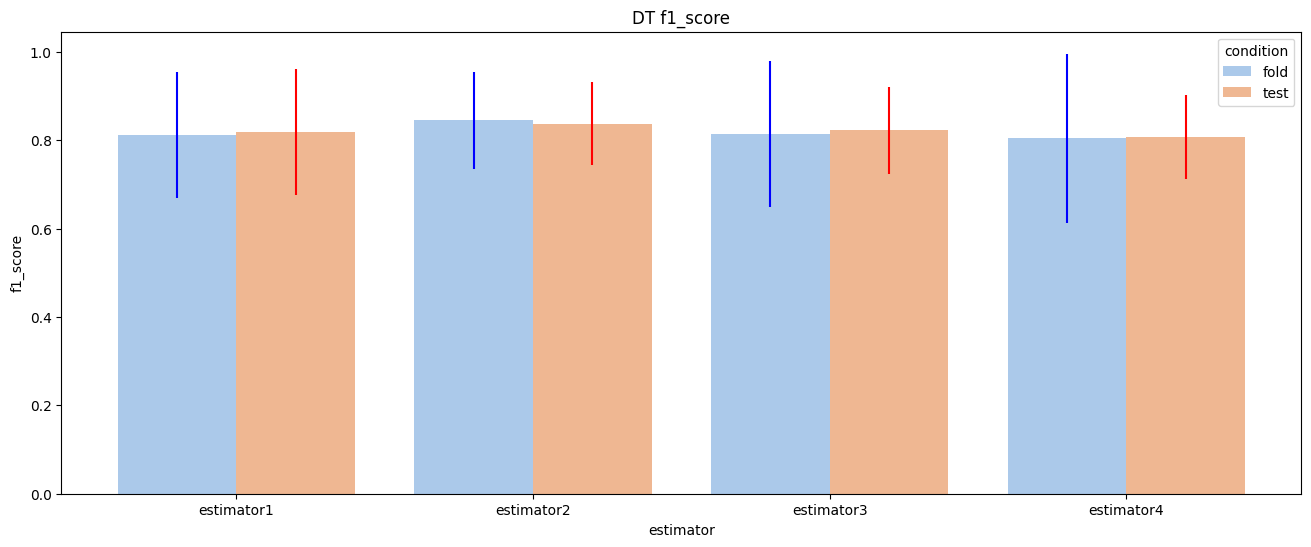

In [ ]:
print(f'Folds mean = {np.mean(folds_mean_dt)}, Folds std = {np.mean(folds_std_dt)}')
print(f'Tests mean = {np.mean(tests_mean_dt)}, Tests std = {np.mean(tests_std_dt)}')

viz_cv(df_dt, title = 'DT')

Folds mean = 0.8696646825396821, Folds std = 0.12189869799844465
Tests mean = 0.8575550838050829, Tests std = 0.09287181825461835


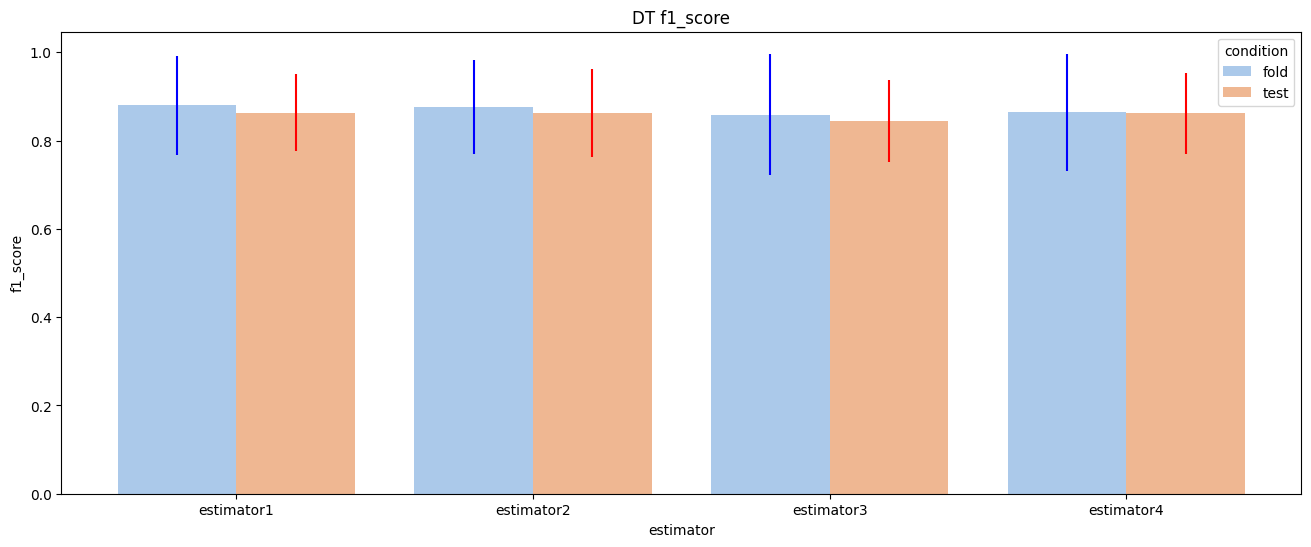

In [ ]:
print(f'Folds mean = {np.mean(folds_mean_dt_red)}, Folds std = {np.mean(folds_std_dt_red)}')
print(f'Tests mean = {np.mean(tests_mean_dt_red)}, Tests std = {np.mean(tests_std_dt_red)}')
viz_cv(df_dt_red, title = 'DT')

In [ ]:
test_on_diff_seeds(DT, x, y)

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


classes  precision_mean  recall_mean   f1_mean
0        0        0.740000     0.746357  0.711527
1        1        0.803333     0.846440  0.808614
2  average        0.771667     0.796399  0.760071

In [ ]:
test_on_diff_seeds(DT, x_np[:,feature_idxs_dt], y_np)

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


classes  precision_mean  recall_mean   f1_mean
0        0        0.747500     0.834024  0.753480
1        1        0.866667     0.859524  0.847659
2  average        0.807083     0.846774  0.800569

## Boosting

### Подбор гиперпараметров

In [ ]:
def objective_boost(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

    # Fit the model
    clf = xgboost.XGBClassifier(**params)

    values = cross_val_score(
        clf, x_train, y_train, n_jobs=-1, cv=4, scoring='f1')

    return values.mean()


study_boost = optuna.create_study(direction='maximize')
study_boost.optimize(objective_boost, n_trials=100)

trial_boost = study_boost.best_trial

print('Boosting BEST F1: {}'.format(trial_boost.value))
print("Best hyperparameters: {}".format(trial_boost.params))


[I 2023-11-22 17:39:43,554] A new study created in memory with name: no-name-53d841f4-785a-4889-89cf-10bc1d629506
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna

Boosting BEST F1: 0.9365079365079365
Best hyperparameters: {'max_depth': 1, 'learning_rate': 0.08467751387215953, 'n_estimators': 450, 'min_child_weight': 1, 'gamma': 0.002089695588891646, 'subsample': 0.5053574013460793, 'colsample_bytree': 0.017492343355474782, 'reg_alpha': 7.543680302655165e-05, 'reg_lambda': 2.23861539324594e-06}


### Оценка

In [ ]:
params = trial_boost.params
BOOST = xgboost.XGBClassifier(**params)

folds_mean_boost, tests_mean_boost, folds_std_boost, tests_std_boost, df_boost = cv_on_diff_seeds(BOOST, x, y)

100%|██████████| 100/100 [00:34<00:00,  2.93it/s]


In [ ]:
feature_idxs_boost = feature_selection(BOOST, x_train, y_train)
folds_mean_boost_red, tests_mean_boost_red, folds_std_boost_red, tests_std_boost_red, df_boost_red = cv_on_diff_seeds(BOOST, x_np[:,feature_idxs_boost], y_np)
print(f'Most importante features: {x.columns[feature_idxs_boost]}')

100%|██████████| 100/100 [00:33<00:00,  3.00it/s]

Most importante features: Index(['P300 O1A50 diff', 'P300 PzA50 diff', 'P300 FzA50 diff',
       'P300 P4A50 diff', 'P300 T5A50 diff', 'P300 P4A80 diff',
       'P300 F4A80 diff'],
      dtype='object')


Folds mean = 0.8875416666666663, Folds std = 0.10397807192460719
Tests mean = 0.8766711205461195, Tests std = 0.07935739148878404


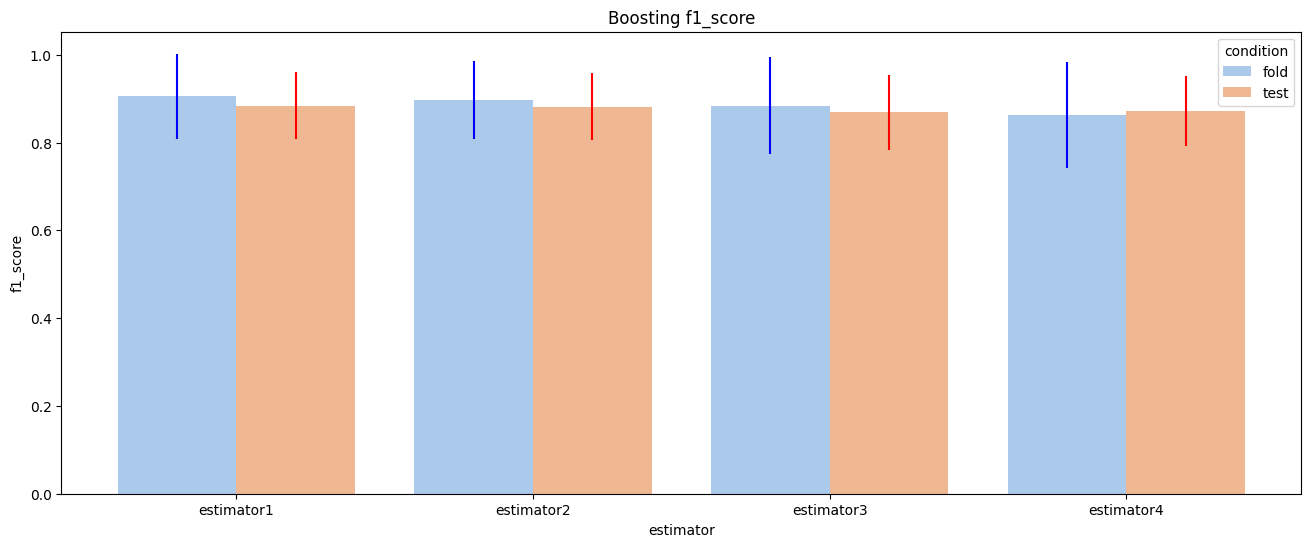

In [ ]:
print(f'Folds mean = {np.mean(folds_mean_boost)}, Folds std = {np.mean(folds_std_boost)}')
print(f'Tests mean = {np.mean(tests_mean_boost)}, Tests std = {np.mean(tests_std_boost)}')

viz_cv(df_boost, title = 'Boosting')

Folds mean = 0.8581448412698407, Folds std = 0.11819010080668524
Tests mean = 0.8435570263070254, Tests std = 0.08669218924280257


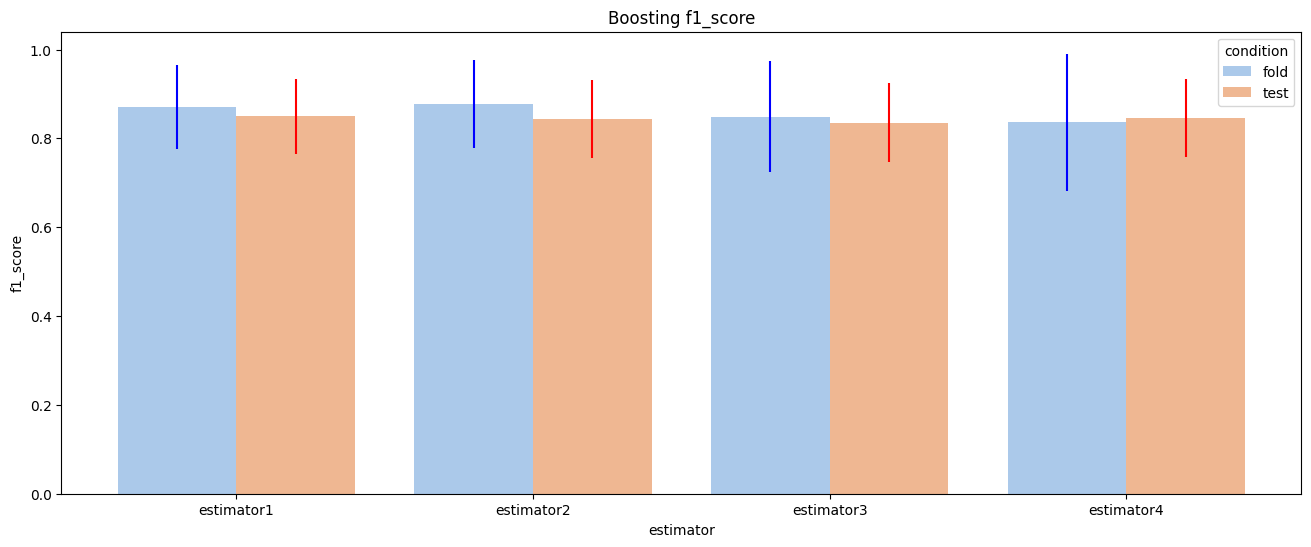

In [ ]:
print(f'Folds mean = {np.mean(folds_mean_boost_red)}, Folds std = {np.mean(folds_std_boost_red)}')
print(f'Tests mean = {np.mean(tests_mean_boost_red)}, Tests std = {np.mean(tests_std_boost_red)}')
viz_cv(df_boost_red, title = 'Boosting')

In [ ]:
test_on_diff_seeds(BOOST, x, y)

classes  precision_mean  recall_mean   f1_mean
0        0         0.73250     0.877667  0.776762
1        1         0.91500     0.849107  0.874480
2  average         0.82375     0.863387  0.825621

In [ ]:
test_on_diff_seeds(BOOST, x_np[:,feature_idxs_boost], y_np)

classes  precision_mean  recall_mean   f1_mean
0        0        0.665000     0.838833  0.713405
1        1        0.898333     0.817381  0.847829
2  average        0.781667     0.828107  0.780617

## SVM polynominal

### Подбор гиперпараметров

In [ ]:
def objective_SVM_poly(trial):


    c = trial.suggest_float('svc_c', 1e-10, 1e10, log=True)
    degree = trial.suggest_int('degree', 0, 6)


    clf = sklearn.svm.SVC(C=c, degree=degree, kernel = 'poly')

    return sklearn.model_selection.cross_val_score(
        clf, x_train, y_train, n_jobs=-1, cv=4, scoring='f1_weighted').mean()

study_SVM_poly = optuna.create_study(direction='maximize')
study_SVM_poly.optimize(objective_SVM_poly, n_trials=100)

trial_SVM_poly = study_SVM_poly.best_trial

print('SVM POLY F1: {}'.format(trial_SVM_poly.value))
print("Best hyperparameters: {}".format(trial_SVM_poly.params))


[I 2023-11-22 17:43:32,843] A new study created in memory with name: no-name-623c1507-58a2-4d03-950c-45c541617052
[I 2023-11-22 17:43:32,885] Trial 0 finished with value: 0.8074074074074074 and parameters: {'svc_c': 4154653.3642913564, 'degree': 3}. Best is trial 0 with value: 0.8074074074074074.
[I 2023-11-22 17:43:32,915] Trial 1 finished with value: 0.42222222222222217 and parameters: {'svc_c': 59.84714874157028, 'degree': 4}. Best is trial 0 with value: 0.8074074074074074.
[I 2023-11-22 17:43:32,952] Trial 2 finished with value: 0.49166666666666664 and parameters: {'svc_c': 5.835075390467139e-05, 'degree': 0}. Best is trial 0 with value: 0.8074074074074074.
[I 2023-11-22 17:43:32,999] Trial 3 finished with value: 0.6275132275132276 and parameters: {'svc_c': 356885.8104658654, 'degree': 5}. Best is trial 0 with value: 0.8074074074074074.
[I 2023-11-22 17:43:33,033] Trial 4 finished with value: 0.49166666666666664 and parameters: {'svc_c': 4.893887398342431e-10, 'degree': 5}. Best is

SVM POLY F1: 0.9537037037037037
Best hyperparameters: {'svc_c': 8.857613915179469, 'degree': 1}


### Оценка

In [ ]:
SVClassifier_poly = SVC(C=trial_SVM_poly.params['svc_c'], degree=trial_SVM_poly.params['degree'], kernel='poly') #linear, poly, sigmoid, rbf

folds_mean_svpoly, tests_mean_svpoly, folds_std_svpoly, tests_std_svpoly, df_svpoly = cv_on_diff_seeds(SVClassifier_poly, x, y)


100%|██████████| 100/100 [00:03<00:00, 25.28it/s]


In [ ]:
feature_idxs_svpoly = feature_selection(SVClassifier_poly, x_train, y_train)
folds_mean_svpoly_red, tests_mean_svpoly_red, folds_std_svpoly_red, tests_std_svpoly_red, df_svpoly_red = cv_on_diff_seeds(SVClassifier_poly, x_np[:,feature_idxs_svpoly], y_np)
print(f'Most importante features: {x.columns[feature_idxs_svpoly]}')


100%|██████████| 100/100 [00:03<00:00, 30.76it/s]

Most importante features: Index(['P300 O1A50 diff', 'P300 O2A50 diff', 'P300 PzA50 diff',
       'P300 FzA50 diff', 'P300 CzA50 diff', 'P300 P4A50 diff',
       'P300 P3A50 diff', 'P300 C4A50 diff', 'P300 C3A50 diff',
       'P300 F3A50 diff', 'P300 F4A50 diff', 'P300 T5A50 diff',
       'P300 T6A50 diff', 'P300 FzA80 diff', 'P300 CzA80 diff',
       'P300 C4A80 diff', 'P300 C3A80 diff'],
      dtype='object')


Folds mean = 0.8893154761904759, Folds std = 0.10970139175673399
Tests mean = 0.8860002081252074, Tests std = 0.09800956195166613


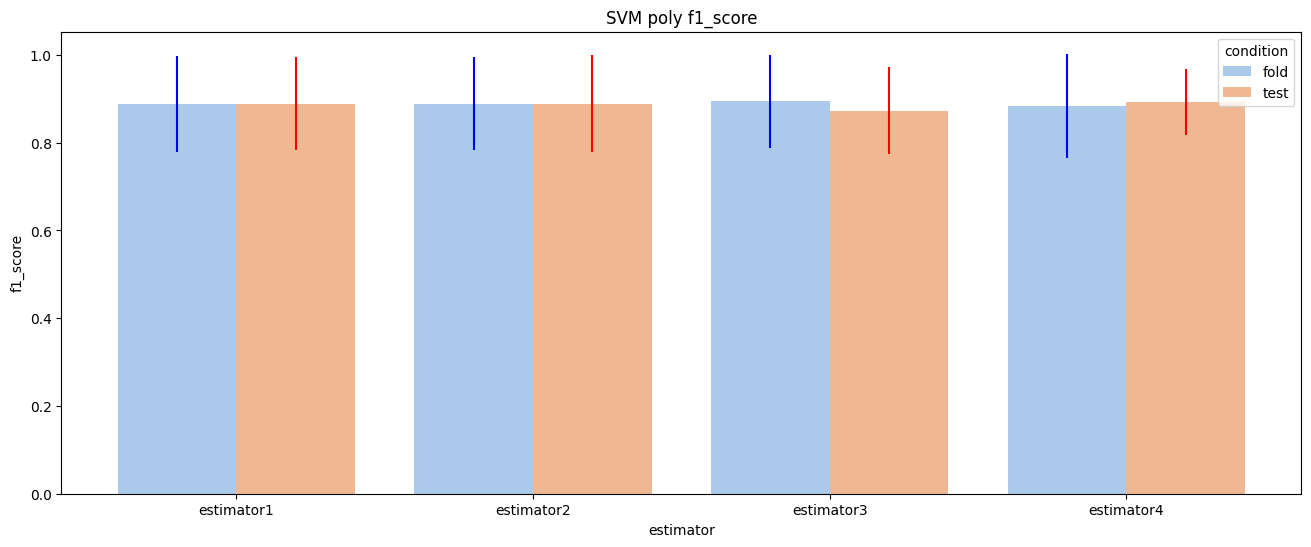

In [ ]:
print(f'Folds mean = {np.mean(folds_mean_svpoly)}, Folds std = {np.mean(folds_std_svpoly)}')
print(f'Tests mean = {np.mean(tests_mean_svpoly)}, Tests std = {np.mean(tests_std_svpoly)}')

viz_cv(df_svpoly, title = 'SVM poly')

Folds mean = 0.920956349206349, Folds std = 0.09936608395821016
Tests mean = 0.9071779331779326, Tests std = 0.0839833879208885


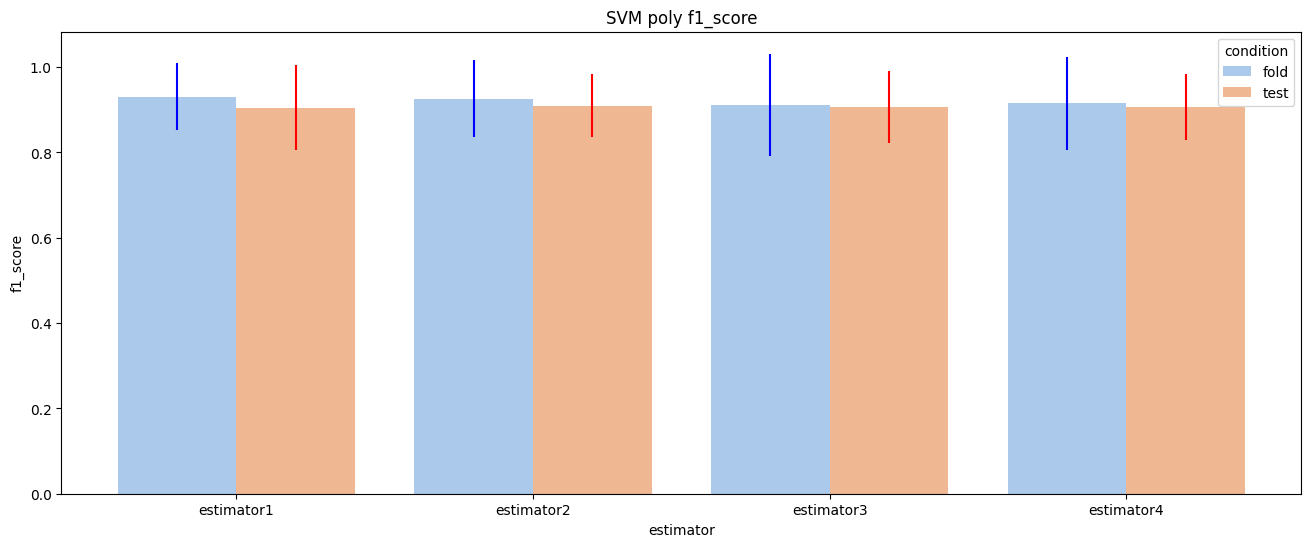

In [ ]:
print(f'Folds mean = {np.mean(folds_mean_svpoly_red)}, Folds std = {np.mean(folds_std_svpoly_red)}')
print(f'Tests mean = {np.mean(tests_mean_svpoly_red)}, Tests std = {np.mean(tests_std_svpoly_red)}')
viz_cv(df_svpoly_red, title = 'SVM poly')


In [ ]:
test_on_diff_seeds(SVClassifier_poly, x, y)

classes  precision_mean  recall_mean   f1_mean
0        0        0.812500     0.877333  0.825000
1        1        0.903333     0.890619  0.889003
2  average        0.857917     0.883976  0.857002

In [ ]:
test_on_diff_seeds(SVClassifier_poly, x_np[:,feature_idxs_svpoly], y_np)

classes  precision_mean  recall_mean   f1_mean
0        0        0.905000     0.871000  0.872873
1        1        0.898333     0.947167  0.916070
2  average        0.901667     0.909083  0.894471

## SVM Sigmoid

### Подбор гиперпараметров

In [ ]:
def objective_SVM_sigm(trial):


    c = trial.suggest_float('svc_c', 1e-10, 1e10, log=True)

    clf = sklearn.svm.SVC(C=c, kernel = 'sigmoid')

    return sklearn.model_selection.cross_val_score(
        clf, x_train, y_train, n_jobs=-1, cv=4, scoring='f1_weighted').mean()

study_SVM_sigm = optuna.create_study(direction='maximize')
study_SVM_sigm.optimize(objective_SVM_sigm, n_trials=100)

trial_SVM_sigm = study_SVM_sigm.best_trial

print('SVM SIGMOID F1: {}'.format(trial_SVM_sigm.value))
print("Best hyperparameters: {}".format(trial_SVM_sigm.params))


[I 2023-11-22 17:45:33,216] A new study created in memory with name: no-name-5ec22c49-eb35-46a5-917a-9e596ed558eb
[I 2023-11-22 17:45:33,256] Trial 0 finished with value: 0.49166666666666664 and parameters: {'svc_c': 0.0030200589888631606}. Best is trial 0 with value: 0.49166666666666664.
[I 2023-11-22 17:45:33,300] Trial 1 finished with value: 0.9037037037037037 and parameters: {'svc_c': 3.6432923309930865}. Best is trial 1 with value: 0.9037037037037037.
[I 2023-11-22 17:45:33,341] Trial 2 finished with value: 0.49166666666666664 and parameters: {'svc_c': 0.00021976528544678095}. Best is trial 1 with value: 0.9037037037037037.
[I 2023-11-22 17:45:33,386] Trial 3 finished with value: 0.49166666666666664 and parameters: {'svc_c': 0.0010816807100589828}. Best is trial 1 with value: 0.9037037037037037.
[I 2023-11-22 17:45:33,424] Trial 4 finished with value: 0.8537037037037036 and parameters: {'svc_c': 266234439.2144473}. Best is trial 1 with value: 0.9037037037037037.
[I 2023-11-22 17:4

SVM SIGMOID F1: 0.9037037037037037
Best hyperparameters: {'svc_c': 3.6432923309930865}


### Оценка

In [ ]:
SVClassifier_sigm = SVC(C=trial_SVM_poly.params['svc_c'], kernel='sigmoid') #linear, poly, sigmoid, rbf

folds_mean_svsigm, tests_mean_svsigm, folds_std_svsigm, tests_std_svsigm, df_svsigm = cv_on_diff_seeds(SVClassifier_sigm, x, y)


100%|██████████| 100/100 [00:04<00:00, 20.06it/s]


In [ ]:
feature_idxs_svsigm = feature_selection(SVClassifier_sigm, x_train, y_train)
folds_mean_svsigm_red, tests_mean_svsigm_red, folds_std_svsigm_red, tests_std_svsigm_red, df_svsigm_red = cv_on_diff_seeds(SVClassifier_sigm, x_np[:,feature_idxs_svsigm], y_np)
print(f'Most importante features: {x.columns[feature_idxs_svsigm]}')

100%|██████████| 100/100 [00:03<00:00, 30.96it/s]

Most importante features: Index(['P300 O1A50 diff', 'P300 O2A50 diff', 'P300 PzA50 diff',
       'P300 FzA50 diff', 'P300 CzA50 diff', 'P300 P4A50 diff',
       'P300 P3A50 diff', 'P300 C4A50 diff', 'P300 C3A50 diff',
       'P300 F3A50 diff', 'P300 F4A50 diff', 'P300 T5A50 diff',
       'P300 T6A50 diff', 'P300 O1A80 diff', 'P300 O2A80 diff',
       'P300 FzA80 diff', 'P300 CzA80 diff', 'P300 P4A80 diff',
       'P300 P3A80 diff', 'P300 C4A80 diff'],
      dtype='object')


Folds mean = 0.8901507936507935, Folds std = 0.10653380515457685
Tests mean = 0.888588619713619, Tests std = 0.09853690073023898


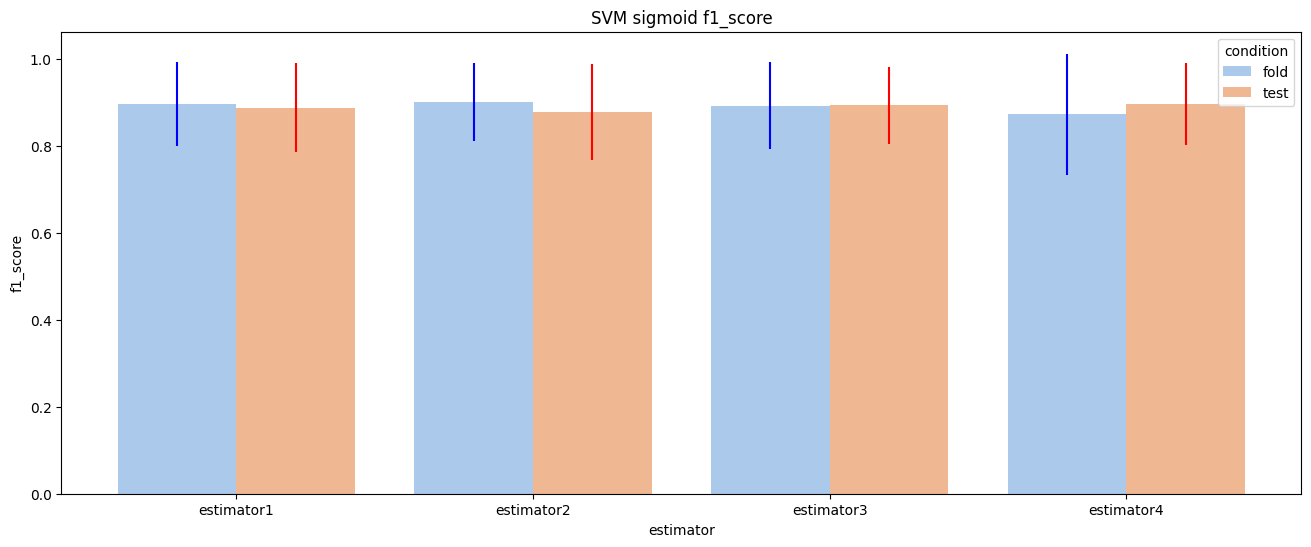

In [ ]:
print(f'Folds mean = {np.mean(folds_mean_svsigm)}, Folds std = {np.mean(folds_std_svsigm)}')
print(f'Tests mean = {np.mean(tests_mean_svsigm)}, Tests std = {np.mean(tests_std_svsigm)}')

viz_cv(df_svsigm, title = 'SVM sigmoid')

Folds mean = 0.9051071428571424, Folds std = 0.10232499237914933
Tests mean = 0.895202547452547, Tests std = 0.0824788745421959


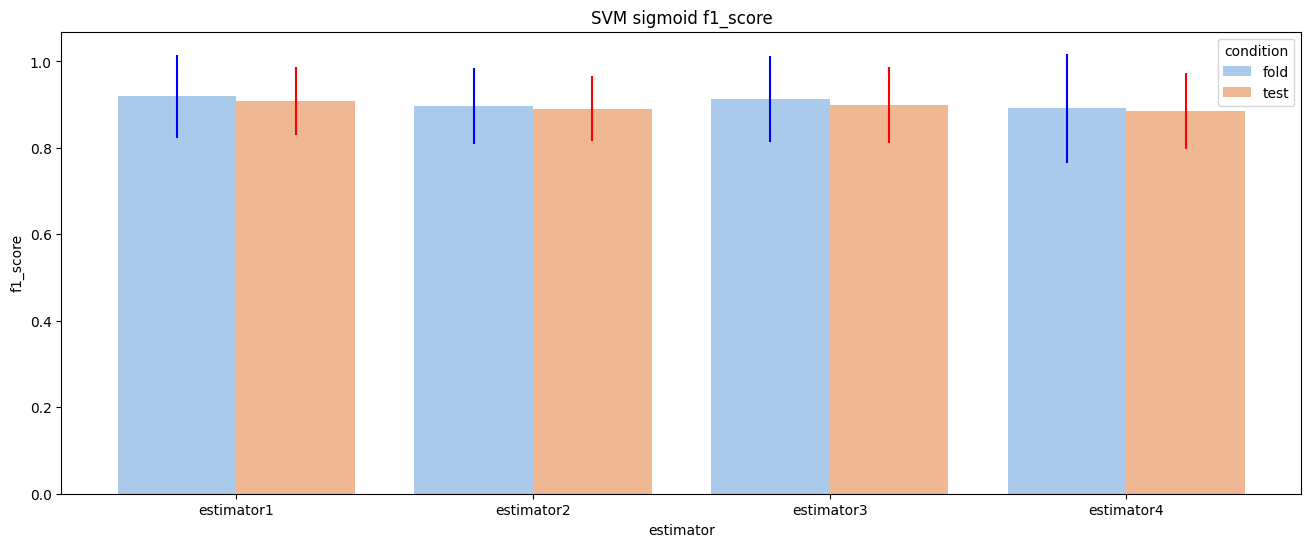

In [ ]:
print(f'Folds mean = {np.mean(folds_mean_svsigm_red)}, Folds std = {np.mean(folds_std_svsigm_red)}')
print(f'Tests mean = {np.mean(tests_mean_svsigm_red)}, Tests std = {np.mean(tests_std_svsigm_red)}')
viz_cv(df_svsigm_red, title = 'SVM sigmoid')

In [ ]:
test_on_diff_seeds(SVClassifier_sigm, x, y)

classes  precision_mean  recall_mean   f1_mean
0        0        0.895000     0.886833  0.878484
1        1        0.903333     0.936714  0.911672
2  average        0.899167     0.911774  0.895078

In [ ]:
test_on_diff_seeds(SVClassifier_sigm, x_np[:,feature_idxs_svsigm], y_np)

classes  precision_mean  recall_mean   f1_mean
0        0        0.852500     0.909333  0.861711
1        1        0.923333     0.915286  0.911450
2  average        0.887917     0.912310  0.886581

## SVM linear

### Подбор гиперпараметров

In [ ]:
def objective_SVM_linear(trial):


    c = trial.suggest_float('svc_c', 1e-10, 1e10, log=True)

    clf = sklearn.svm.SVC(C=c, kernel = 'linear')

    return sklearn.model_selection.cross_val_score(
        clf, x_train, y_train, n_jobs=-1, cv=4, scoring='f1_weighted').mean()

study_SVM_linear = optuna.create_study(direction='maximize')
study_SVM_linear.optimize(objective_SVM_linear, n_trials=100)

trial_SVM_linear = study_SVM_linear.best_trial

print('SVM LINEAR F1: {}'.format(trial_SVM_linear.value))
print("Best hyperparameters: {}".format(trial_SVM_linear.params))

[I 2023-11-22 17:46:50,149] A new study created in memory with name: no-name-9afe9817-4042-4da5-bee2-282a49378ddc
[I 2023-11-22 17:46:50,194] Trial 0 finished with value: 0.8409523809523808 and parameters: {'svc_c': 0.015168616500897925}. Best is trial 0 with value: 0.8409523809523808.
[I 2023-11-22 17:46:50,237] Trial 1 finished with value: 0.8657142857142857 and parameters: {'svc_c': 0.05628488807370728}. Best is trial 1 with value: 0.8657142857142857.
[I 2023-11-22 17:46:50,283] Trial 2 finished with value: 0.8657142857142857 and parameters: {'svc_c': 0.20291241147959654}. Best is trial 1 with value: 0.8657142857142857.
[I 2023-11-22 17:46:50,320] Trial 3 finished with value: 0.7928571428571429 and parameters: {'svc_c': 3361320557.364867}. Best is trial 1 with value: 0.8657142857142857.
[I 2023-11-22 17:46:50,372] Trial 4 finished with value: 0.7928571428571429 and parameters: {'svc_c': 19.24092666006047}. Best is trial 1 with value: 0.8657142857142857.
[I 2023-11-22 17:46:50,421] T

SVM LINEAR F1: 0.9561904761904761
Best hyperparameters: {'svc_c': 0.44243449406240803}


### Оценка

In [ ]:
SVClassifier_lin = SVC(C=trial_SVM_poly.params['svc_c'], kernel='linear')

folds_mean_svlin, tests_mean_svlin, folds_std_svlin, tests_std_svlin, df_svlin = cv_on_diff_seeds(SVClassifier_lin, x, y)


100%|██████████| 100/100 [00:04<00:00, 24.93it/s]


In [ ]:
feature_idxs_svlin = feature_selection(SVClassifier_lin, x_train, y_train)
folds_mean_svlin_red, tests_mean_svlin_red, folds_std_svlin_red, tests_std_svlin_red, df_svlin_red = cv_on_diff_seeds(SVClassifier_lin, x_np[:,feature_idxs_svlin], y_np)
print(f'Most importante features: {x.columns[feature_idxs_svlin]}')

100%|██████████| 100/100 [00:03<00:00, 31.45it/s]

Most importante features: Index(['P300 O2A50 diff', 'P300 FzA50 diff', 'P300 CzA50 diff',
       'P300 P4A50 diff', 'P300 P3A50 diff', 'P300 C4A50 diff',
       'P300 C3A50 diff', 'P300 F3A50 diff', 'P300 F4A50 diff',
       'P300 T5A50 diff', 'P300 T6A50 diff', 'P300 FzA80 diff',
       'P300 CzA80 diff', 'P300 C4A80 diff', 'P300 C3A80 diff',
       'P300 F3A80 diff', 'P300 F4A80 diff'],
      dtype='object')


Folds mean = 0.8831071428571426, Folds std = 0.11427538100055384
Tests mean = 0.8780628954378948, Tests std = 0.09939859786027876


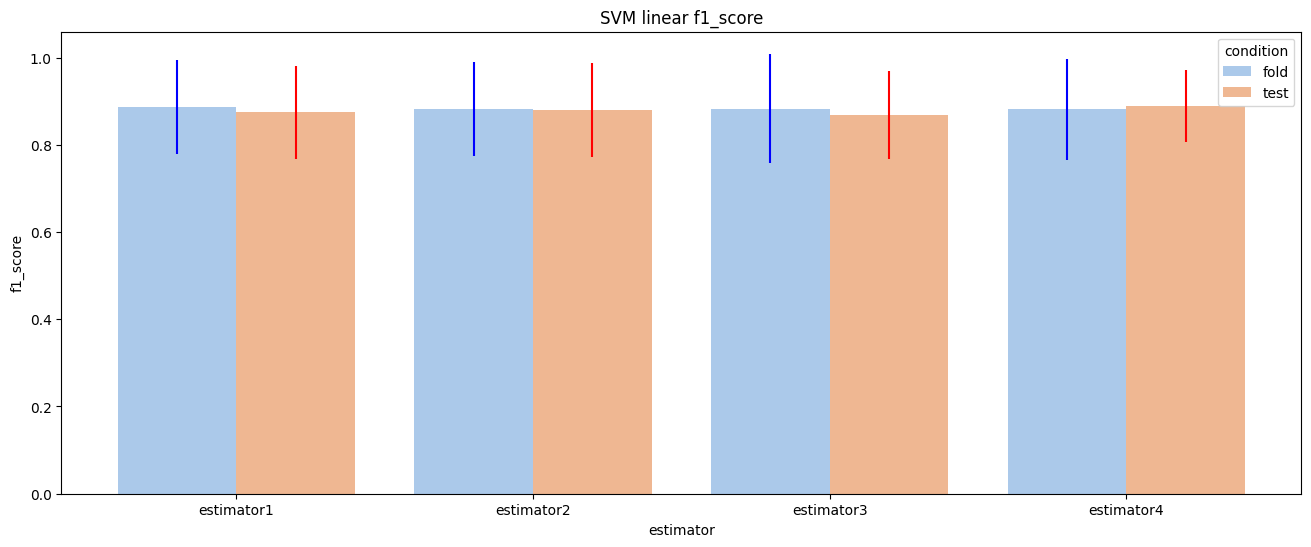

In [ ]:
print(f'Folds mean = {np.mean(folds_mean_svlin)}, Folds std = {np.mean(folds_std_svlin)}')
print(f'Tests mean = {np.mean(tests_mean_svlin)}, Tests std = {np.mean(tests_std_svlin)}')

viz_cv(df_svlin, title = 'SVM linear')

Folds mean = 0.9180079365079362, Folds std = 0.10859225370492581
Tests mean = 0.9065768675768668, Tests std = 0.10789138410601301


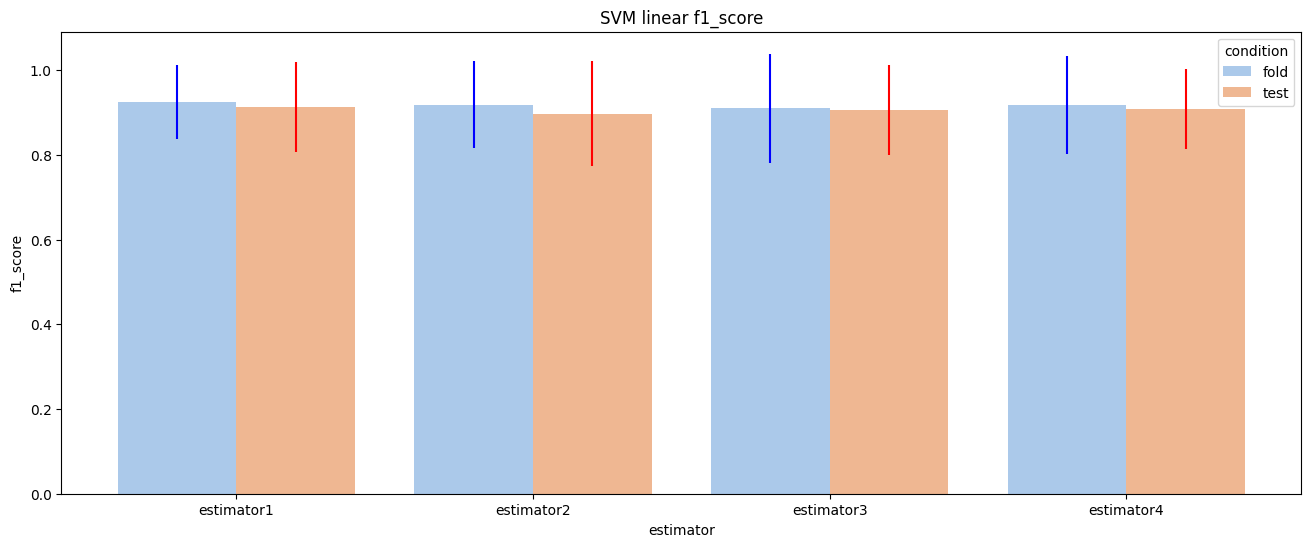

In [ ]:
print(f'Folds mean = {np.mean(folds_mean_svlin_red)}, Folds std = {np.mean(folds_std_svlin_red)}')
print(f'Tests mean = {np.mean(tests_mean_svlin_red)}, Tests std = {np.mean(tests_std_svlin_red)}')
viz_cv(df_svlin_red, title = 'SVM linear')

In [ ]:
test_on_diff_seeds(SVClassifier_lin, x, y)

classes  precision_mean  recall_mean   f1_mean
0        0        0.815000     0.847833  0.812627
1        1        0.883333     0.891036  0.878948
2  average        0.849167     0.869435  0.845787

In [ ]:
test_on_diff_seeds(SVClassifier_lin, x_np[:,feature_idxs_svlin], y_np)

classes  precision_mean  recall_mean   f1_mean
0        0        0.960000     0.872944  0.907194
1        1        0.888333     0.973690  0.922056
2  average        0.924167     0.923317  0.914625

## SVM RBF

### Подбор гиперпараметров

In [ ]:
def objective_SVM_RBF(trial):


    c = trial.suggest_float('svc_c', 10e-3, 10e3, log=True)
    gamma = trial.suggest_float('gamma', 0, 1)

    clf = sklearn.svm.SVC(C=c, gamma=gamma, kernel = 'rbf')

    return sklearn.model_selection.cross_val_score(
        clf, x_train, y_train, n_jobs=-1, cv=4, scoring='f1_weighted').mean()

study_SVM_rbf = optuna.create_study(direction='maximize')
study_SVM_rbf.optimize(objective_SVM_RBF, n_trials=100)

trial_SVM_rbf = study_SVM_rbf.best_trial

print('SVM RBF F1: {}'.format(trial_SVM_rbf.value))
print("Best hyperparameters: {}".format(trial_SVM_rbf.params))

[I 2023-11-22 17:57:15,368] A new study created in memory with name: no-name-d2962610-084c-4901-af0a-b85930440351
[I 2023-11-22 17:57:15,406] Trial 0 finished with value: 0.49166666666666664 and parameters: {'svc_c': 0.3935201873832138, 'gamma': 0.3569603328212698}. Best is trial 0 with value: 0.49166666666666664.
[I 2023-11-22 17:57:15,435] Trial 1 finished with value: 0.49166666666666664 and parameters: {'svc_c': 0.12531375265127578, 'gamma': 0.1797392588036485}. Best is trial 0 with value: 0.49166666666666664.
[I 2023-11-22 17:57:15,458] Trial 2 finished with value: 0.49166666666666664 and parameters: {'svc_c': 1.7622325660769498, 'gamma': 0.490011115803214}. Best is trial 0 with value: 0.49166666666666664.
[I 2023-11-22 17:57:15,485] Trial 3 finished with value: 0.7526455026455027 and parameters: {'svc_c': 921.1096078375313, 'gamma': 0.028005263863646324}. Best is trial 3 with value: 0.7526455026455027.
[I 2023-11-22 17:57:15,507] Trial 4 finished with value: 0.49166666666666664 an

SVM RBF F1: 0.9537037037037037
Best hyperparameters: {'svc_c': 630.2114346103922, 'gamma': 0.000314003326405958}


### Оценка

In [ ]:
SVClassifier_rbf = SVC(C=trial_SVM_rbf.params['svc_c'], gamma = trial_SVM_rbf.params['gamma'], kernel='rbf') #linear, poly, sigmoid, rbf

folds_mean_svrbf, tests_mean_svrbf, folds_std_svrbf, tests_std_svrbf, df_svrbf = cv_on_diff_seeds(SVClassifier_rbf, x, y)


100%|██████████| 100/100 [00:06<00:00, 15.33it/s]


In [ ]:
feature_idxs_svrbf = feature_selection(SVClassifier_rbf, x_train, y_train)
folds_mean_svrbf_red, tests_mean_svrbf_red, folds_std_svrbf_red, tests_std_svrbf_red, df_svrbf_red = cv_on_diff_seeds(SVClassifier_rbf, x_np[:,feature_idxs_svrbf], y_np)
print(f'Most importante features: {x.columns[feature_idxs_svrbf]}')

100%|██████████| 100/100 [00:03<00:00, 31.96it/s]

Most importante features: Index(['P300 O1A50 diff', 'P300 O2A50 diff', 'P300 PzA50 diff',
       'P300 FzA50 diff', 'P300 CzA50 diff', 'P300 P4A50 diff',
       'P300 P3A50 diff', 'P300 C4A50 diff', 'P300 C3A50 diff',
       'P300 F3A50 diff', 'P300 F4A50 diff', 'P300 T6A50 diff',
       'P300 FzA80 diff', 'P300 CzA80 diff', 'P300 C4A80 diff',
       'P300 C3A80 diff', 'P300 F3A80 diff', 'P300 T5A80 diff',
       'P300 T6A80 diff'],
      dtype='object')


Folds mean = 0.8879999999999997, Folds std = 0.10990898824746936
Tests mean = 0.8852492091242085, Tests std = 0.09967587432340182


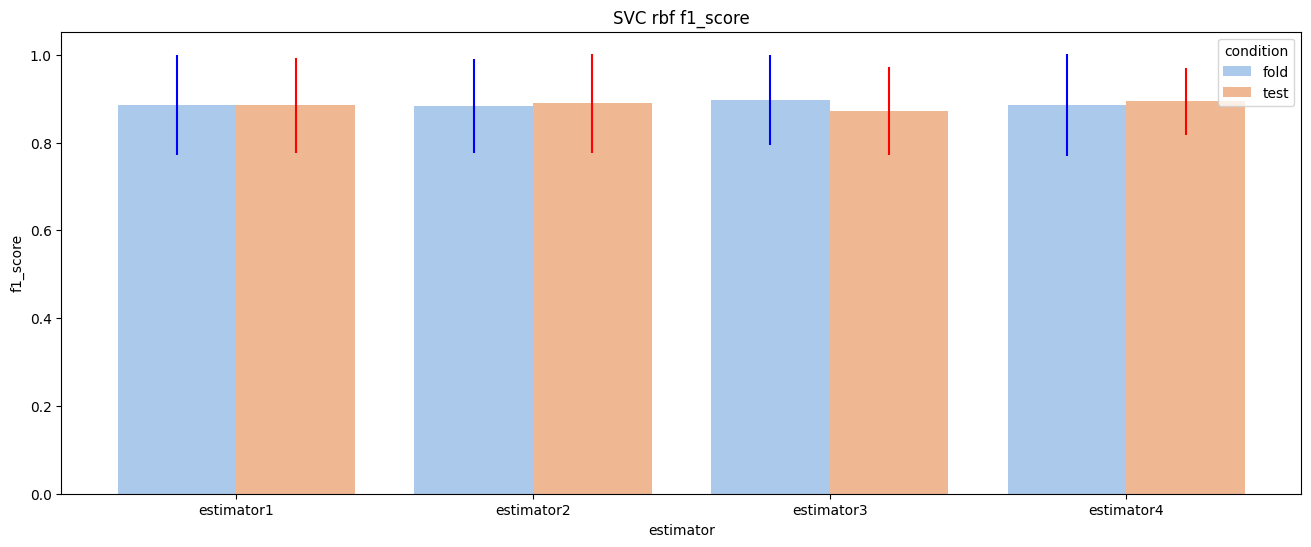

In [ ]:
print(f'Folds mean = {np.mean(folds_mean_svrbf)}, Folds std = {np.mean(folds_std_svrbf)}')
print(f'Tests mean = {np.mean(tests_mean_svrbf)}, Tests std = {np.mean(tests_std_svrbf)}')

viz_cv(df_svrbf, title = 'SVC rbf')

Folds mean = 0.9055476190476187, Folds std = 0.10229684607433061
Tests mean = 0.9021276223776218, Tests std = 0.0874918057634189


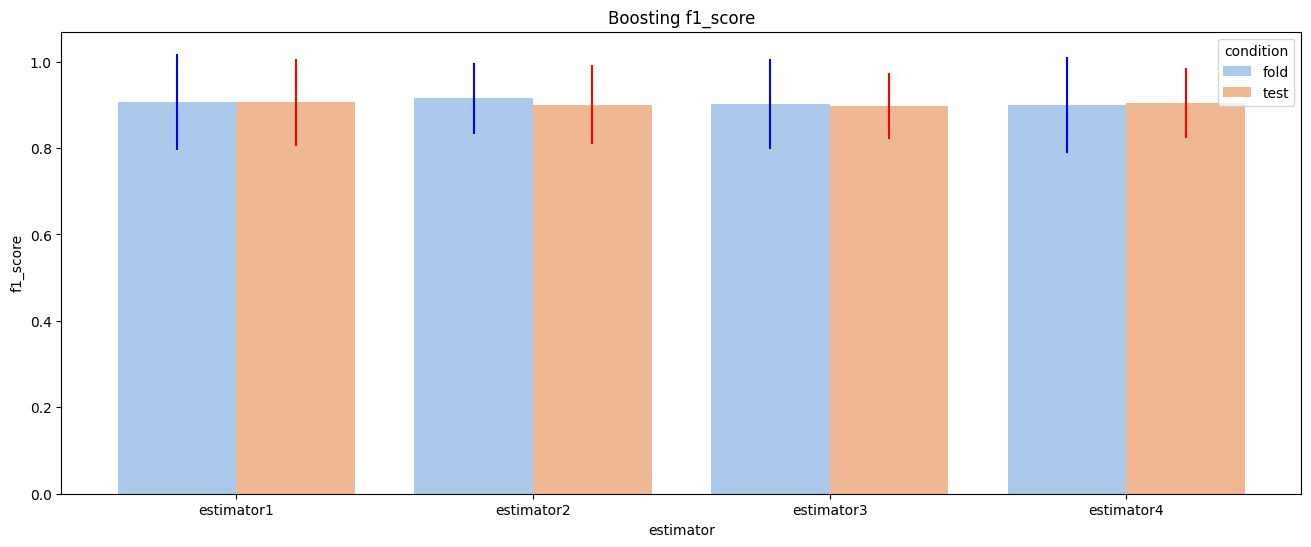

In [ ]:
print(f'Folds mean = {np.mean(folds_mean_svrbf_red)}, Folds std = {np.mean(folds_std_svrbf_red)}')
print(f'Tests mean = {np.mean(tests_mean_svrbf_red)}, Tests std = {np.mean(tests_std_svrbf_red)}')
viz_cv(df_svrbf_red, title = 'Boosting')

In [ ]:
test_on_diff_seeds(SVClassifier_rbf, x, y)

classes  precision_mean  recall_mean   f1_mean
0        0        0.820000     0.868000  0.827222
1        1        0.898333     0.892881  0.888441
2  average        0.859167     0.880440  0.857831

In [ ]:
test_on_diff_seeds(SVClassifier_rbf, x_np[:,feature_idxs_svrbf], y_np)

classes  precision_mean  recall_mean   f1_mean
0        0        0.845000     0.879214  0.846043
1        1        0.908333     0.909262  0.902833
2  average        0.876667     0.894238  0.874438

# **Explainability**


## Random Forest

In [ ]:
RF = RandomForestClassifier(n_estimators=trial_RF.params['n_estimators'], max_depth=trial_RF.params['max_depth'], random_state = 83)


In [ ]:
RF.fit(x_train, y_train)

RandomForestClassifier(max_depth=13, n_estimators=17, random_state=83)

In [ ]:
x_test_df = pd.DataFrame(x_test, columns = list(x.columns))
x_train_df = pd.DataFrame(x_train, columns = list(x.columns))

In [ ]:
explainer_RF = shap.TreeExplainer(RF)
shap_values_RF = explainer_RF.shap_values(x_test_df)

In [ ]:
# load JS visualization code to notebook
shap.initjs()
# visualize the first prediction’s explanation
shap.force_plot(explainer_RF.expected_value[1], shap_values_RF[1][0, :], x_test_df.iloc[0, :])

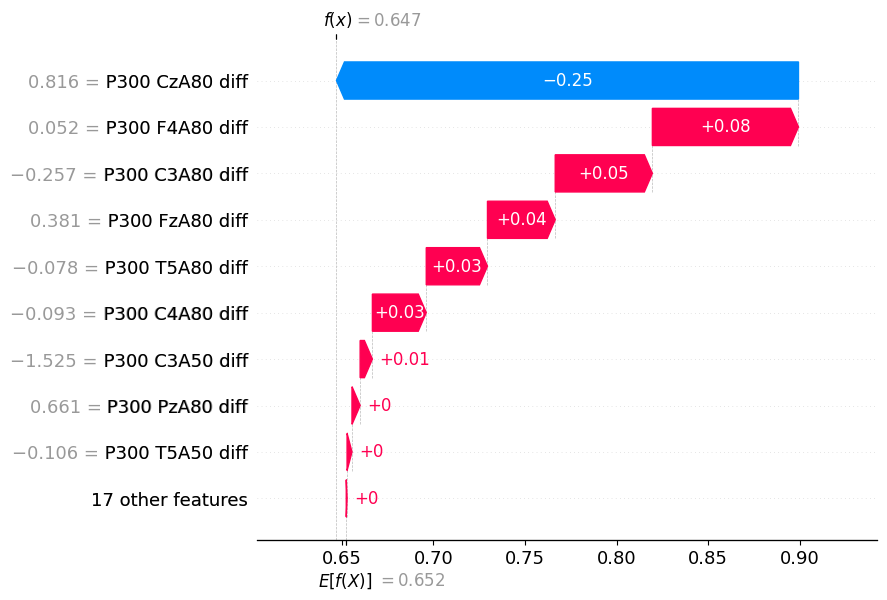

In [ ]:
explainer_RF_for_wf = shap.Explainer(RF, x_train_df)
exlanation_RF = explainer_RF_for_wf(x_test_df)

shap.plots.waterfall(exlanation_RF[8, :, 1]) # object, features, class

In [ ]:
# load JS visualization code to notebook
shap.initjs()
# visualize the training set predictions
shap.force_plot(explainer_RF.expected_value[1], shap_values_RF[1], x_test_df)

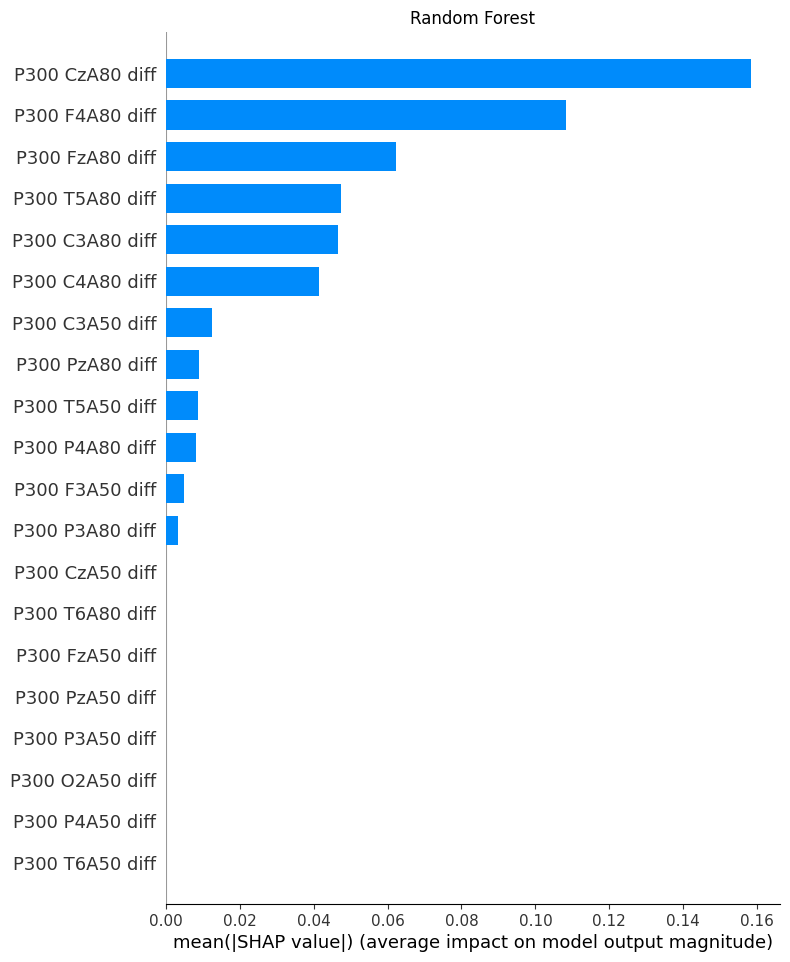

In [ ]:
shap.summary_plot(shap_values_RF[0], x_test_df, plot_type="bar", show=False)
plt.title('Random Forest')
plt.show()


## SVM

In [ ]:
SVClassifier_sigm = SVC(C=trial_SVM_poly.params['svc_c'], kernel='sigmoid') #linear, poly, sigmoid, rbf
SVClassifier_sigm.fit(x_train, y_train)

SVC(C=8.857613915179469, kernel='sigmoid')

In [ ]:
explainer_SVM = shap.KernelExplainer(SVClassifier_sigm.predict, x_train_df)
shap_values_SVM = explainer_SVM.shap_values(x_test_df)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# load JS visualization code to notebook
shap.initjs()
# visualize the first prediction’s explanation
shap.force_plot(explainer_SVM.expected_value, shap_values_SVM[6, :], x_test_df.iloc[6, :])

In [ ]:
# load JS visualization code to notebook
shap.initjs()
# visualize the training set predictions
shap.force_plot(explainer_SVM.expected_value, shap_values_SVM, x_test_df)

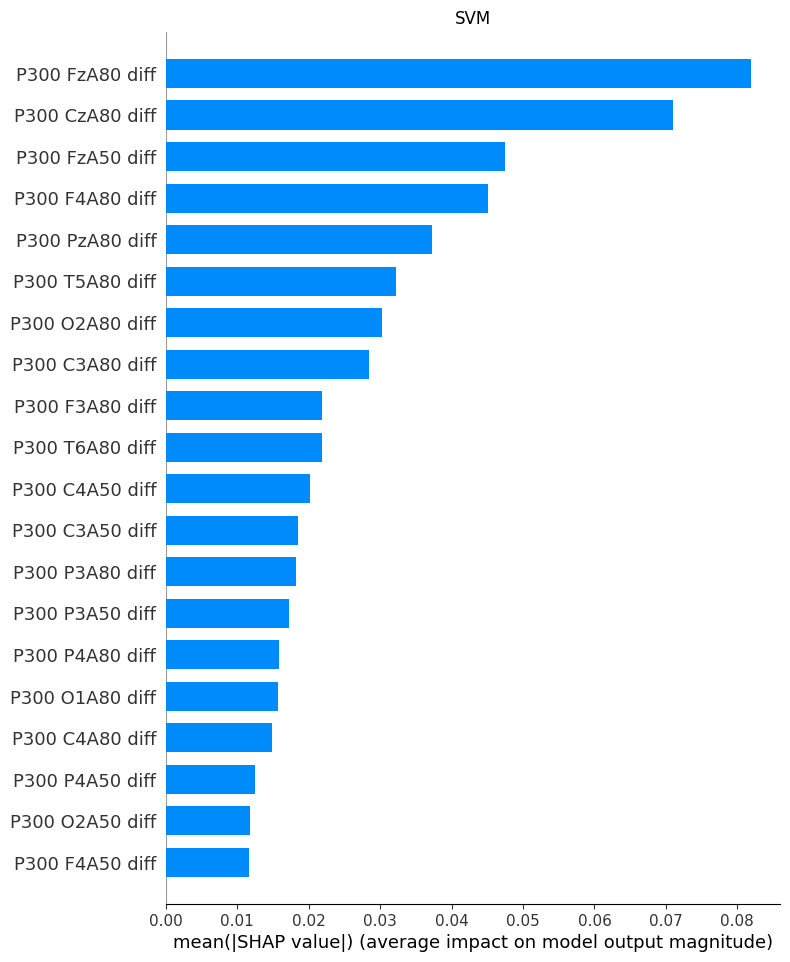

In [ ]:
shap.summary_plot(shap_values_SVM, x_test_df, plot_type="bar", show=False)
plt.title('SVM')
plt.show()